## Making Custom Tools

####  making a tool to caption images 


In [6]:
from PIL import Image
import requests
from langchain.agents import initialize_agent

from langchain.tools import BaseTool

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

In [3]:
# setup cuda, model
hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

c:\Users\liujj\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\liujj\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


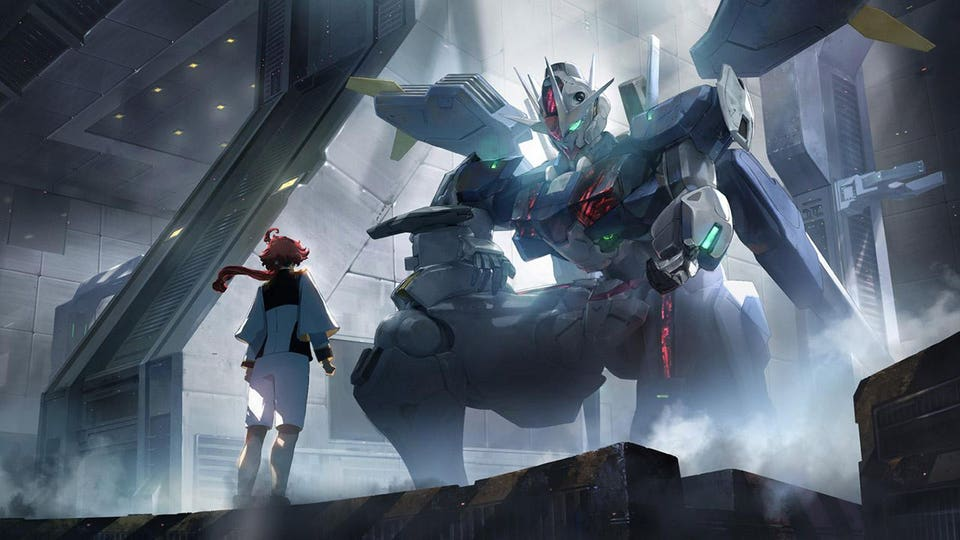

In [4]:
img_url = 'https://imageio.forbes.com/specials-images/imageserve/63bad203bd63d9ba98f26064/Gundam--The-Witch-from-Mercury/0x0.jpg?format=jpg&crop=1280,720,x0,y0,safe&width=960' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [5]:
# unconditional image captioning
inputs = processor(image, return_tensors="pt").to(device)

out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))

anime characters standing in front of a giant robot in a futuristic setting


In [23]:
desc = (
    "use this tool when given an URL of an image that you'd like to be described. It will return a caption describing the image."
)

class ImageCaptioningTool(BaseTool):
    name = 'image captioner'
    description = desc
    
    def init_model(self):
        hf_model = "Salesforce/blip-image-captioning-large"
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        processor = BlipProcessor.from_pretrained(hf_model)
        model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)
        return device, processor, model
    
    def _run(self, url: str):
        # read image
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # initialize model        
        device, processor, model = self.init_model()
        # send image to model and generate output
        inputs = processor(image, return_tensors="pt").to(device)
        out = model.generate(**inputs, max_new_tokens=20)
        return processor.decode(out[0], skip_special_tokens=True)
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")
    
tools = [ImageCaptioningTool()]

In [24]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from constants import keys

# set prompt. This is very similar to default prompt. Change this if you need to force model to use a particular tool
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

os.environ['OPENAI_API_KEY'] = keys['openai']

# initialize LLM (we use ChatOpenAI because we'll later define a `chat` agent)
llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo'
)
# initialize conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

# initialize agent with tools
agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

In [25]:
agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0fcf413fba1a5aa9f47a55bbfc8bdae8 in your message.).


{
    "action": "image captioner",
    "action_input": "https://imageio.forbes.com/specials-images/imageserve/63bad203bd63d9ba98f26064/Gundam--The-Witch-from-Mercury/0x0.jpg?format=jpg&crop=1280,720,x0,y0,safe&width=960"
}
Observation: anime characters standing in front of a giant robot in a futuristic setting
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows anime characters standing in front of a giant robot in a futuristic setting."
}

> Finished chain.


{'input': 'What does this image show?\nhttps://imageio.forbes.com/specials-images/imageserve/63bad203bd63d9ba98f26064/Gundam--The-Witch-from-Mercury/0x0.jpg?format=jpg&crop=1280,720,x0,y0,safe&width=960',
 'chat_history': [],
 'output': 'The image shows anime characters standing in front of a giant robot in a futuristic setting.'}

In [27]:
img_url = "https://media.wired.com/photos/615cb6377aac0c0d8e7cfb3f/191:100/w_1280,c_limit/Gear-Nintendo-Switch-OLED.jpg"
agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "image captioner",
    "action_input": "https://media.wired.com/photos/615cb6377aac0c0d8e7cfb3f/191:100/w_1280,c_limit/Gear-Nintendo-Switch-OLED.jpg"
}
Observation: nintendo switch logo on a screen with a green background
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows the Nintendo Switch logo on a screen with a green background."
}

> Finished chain.


{'input': 'What does this image show?\nhttps://media.wired.com/photos/615cb6377aac0c0d8e7cfb3f/191:100/w_1280,c_limit/Gear-Nintendo-Switch-OLED.jpg',
 'chat_history': [HumanMessage(content='What does this image show?\nhttps://imageio.forbes.com/specials-images/imageserve/63bad203bd63d9ba98f26064/Gundam--The-Witch-from-Mercury/0x0.jpg?format=jpg&crop=1280,720,x0,y0,safe&width=960', additional_kwargs={}),
  AIMessage(content='The image shows anime characters standing in front of a giant robot in a futuristic setting.', additional_kwargs={})],
 'output': 'The image shows the Nintendo Switch logo on a screen with a green background.'}

## Tool List
1. Image Captioning - huggingface Salesforce/blip-image-captioning-large
2. Image generation - dalle 
3. Search - DuckDuckGo API
4. Technews - hackernews 
5. 

In [29]:
from duckduckgo_search import ddg

ddg('what is the current tallest building in the world?')

[{'title': 'Burj Khalifa | Height, Architect, Top Floor, & Facts | Britannica',
  'href': 'https://www.britannica.com/topic/Burj-Khalifa',
  'body': 'Burj Khalifa, Khalifa also spelled Khalīfah, mixed-use skyscraper in Dubai, United Arab Emirates, that is the world\'s tallest building, according to all three of the main criteria by which such buildings are judged (see Researcher\'s Note: Heights of Buildings). Burj Khalifa ("Khalifa Tower"), known during construction as Burj Dubai, was officially named to honour the leader of the ...'},
 {'title': 'List of tallest buildings - Wikipedia',
  'href': 'https://en.wikipedia.org/wiki/List_of_tallest_buildings',
  'body': "Historically, the world's tallest man-made structure was the Great Pyramid of Giza in Egypt, which held the position for over 3800 years until the construction of Lincoln Cathedral in 1311. The Strasbourg Cathedral in France, completed in 1439, was the world's tallest building until 1874.. The first skyscraper was pioneered